In [1]:
""":
Deep Learning Assignment 3
Conditional GAN Skeleton Code.
Adopted from public sources, customized and improved for this assignment.
"""

#import necessary modules
import torch
import torch.nn as nn
from torchvision import transforms, datasets
from torch import optim as optim
# for visualization
from matplotlib import pyplot as plt
import math
import numpy as np

In [2]:

# tells PyTorch to use an NVIDIA GPU, if one is available.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# loading the dataset
training_parameters = {
    "img_size": 28,
    "n_epochs": 2, #24
    "batch_size": 64,
    "learning_rate_generator": 0.0002,
    "learning_rate_discriminator": 0.0002,
}
# define a transform to 1) scale the images and 2) convert them into tensors
transform = transforms.Compose([
    transforms.Resize(training_parameters['img_size']), # scales the smaller edge of the image to have this size
    transforms.ToTensor(),
])

# load the dataset
train_loader = torch.utils.data.DataLoader(
    datasets.FashionMNIST(
        './data', # specifies the directory to download the datafiles to, relative to the location of the notebook.
        train = True,
        download = True,
        transform = transform),
    batch_size = training_parameters["batch_size"],
    shuffle=True
    )

# Fashion MNIST has 10 classes, just like MNIST. Here's what they correspond to:
label_descriptions = {
      0: 'T-shirt/top',
      1	: 'Trouser',
      2	: 'Pullover',
      3	: 'Dress',
      4	: 'Coat',
      5	: 'Sandal',
      6	: 'Shirt',
      7	: 'Sneaker',
      8	: 'Bag',
      9	: 'Ankle boot'
}

In [3]:

# Create the Generator model class, which will be used to initialize the generator
class Generator(nn.Module):
  def __init__(self, input_dim, output_dim, num_labels=10): # to initialize the model-wide parameters. When you run `generator = Generator(params)`, those "params" are passed to __init__.
    super(Generator,self).__init__() # initialize the parent class
    # TODO (5.4) Turn this Generator into a Conditional Generator by
    # 1. Adjusting the input dimension of the first hidden layer.
    # 2. Modifying the input to the first hidden layer in the forward class.
    # self.label_embedding = nn.Embedding(10, 10) # This function will be useful.
    self.hidden_layer1 = nn.Sequential(
        nn.Linear(input_dim, 256),
        nn.LeakyReLU(0.2)
    )
    self.hidden_layer2 = nn.Sequential(
        nn.Linear(256, 512),
        nn.LeakyReLU(0.2)
    )
    self.hidden_layer3 = nn.Sequential(
        nn.Linear(512, 1024),
        nn.LeakyReLU(0.2)
    )
    self.hidden_layer4 = nn.Sequential(
        nn.Linear(1024, output_dim),
        nn.Tanh()
    )
  def forward(self, x, labels):
      output = self.hidden_layer1(x)
      output = self.hidden_layer2(output)
      output = self.hidden_layer3(output)
      output = self.hidden_layer4(output)
      return output.to(device)

In [4]:
class Discriminator(nn.Module):
    def __init__(self, input_dim, output_dim=1, num_labels=None):
        super(Discriminator, self).__init__()
        # TODO (5.4) Modify this discriminator to function as a conditional discriminator.
        self.hidden_layer1 = nn.Sequential(
            nn.Linear(input_dim, 1024),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3)
        )

        self.hidden_layer2 = nn.Sequential(
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3)
        )

        self.hidden_layer3 = nn.Sequential(
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3)
        )

        self.hidden_layer4 = nn.Sequential(
            nn.Linear(256, output_dim),
            nn.Sigmoid()
        )

    def forward(self, x, labels=None): # labels to be used in 5.4.
        output = self.hidden_layer1(x)
        output = self.hidden_layer2(output)
        output = self.hidden_layer3(output)
        output = self.hidden_layer4(output)
        return output.to(device)

In [5]:
discriminator = Discriminator(784,1).to(device) # initialize both models, and load them to the GPU or CPU.
generator = Generator(100,784).to(device)

discriminator_optimizer = optim.Adam(discriminator.parameters(), lr=training_parameters['learning_rate_discriminator'])
generator_optimizer = optim.Adam(generator.parameters(), lr=training_parameters['learning_rate_generator'])

In [6]:
# TODO: Implement the GAN training procedure.
#Loss_D - discriminator loss calculated as the sum of losses for the all real and all fake batches $(\log (D(x))+\log (1- D(G(z))))

loss_func = nn.BCELoss() # Binary Cross Entropy Loss
def train_generator(batch_size):
    """
    Performs a training step on the generator by
        1. Generating fake images from random noise.
        2. Running the discriminator on the fake images.
        3. Computing loss on the result.
    :arg batch_size: the number of training examples in the current batch
    Returns the average generator loss over the batch.
    """
    # TODO: This function should perform a single training step on the generator
    # Start by zeroing the gradients of the optimizer
    generator_optimizer.zero_grad() #TODO 
    # 1. Create a new batch of fake images (since the discriminator has just been trained on the old ones)
    noise = torch.randn(batch_size,100).to(device) # whenever you create new variables for the model to process, send them to the device, like this.
    # ...
    generator_output = generator(noise, labels = None) 
    # 2. Run the discriminator on the fake images
    discriminator_output = discriminator(generator_output)
    # 3. Compute the loss
    loss = loss_func(discriminator_output, torch.ones(batch_size,1).to(device)) #TODO
    loss.backward()
    generator_optimizer.step()

    loss = loss.mean().item()
    return loss

def train_discriminator(batch_size, images, labels=None): # labels to be used in 5.4.
    """
    Performs a training step on the discriminator by
        1. Generating fake images from random noise.
        2. Running the discriminator on the fake images.
        3. Running the discriminator on the real images
        3. Computing loss on the results.
    :arg batch_size: the number of training examples in the current batch
    :arg images: the current batch of images, a tensor of size BATCH x 1 x 64 x 64
    :arg labels: the labels corresponding to images, a tensor of size BATCH
    Returns the average loss over the batch.
    """
    # TODO: And this function should perform a single training step on the discriminator
    discriminator_optimizer.zero_grad()
    ###----fake images----###
    # 1. Create a new batch of fake images (since the discriminator has just been trained on the old ones)
    noise = torch.randn(batch_size,100).to(device) # whenever you create new variables for the model to process, send them to the device, like this.
    # ...
    generator_output = generator(noise, labels = None) 
    # 2. Run the discriminator on the fake images
    discriminator_output = discriminator(generator_output)
    # 3. Compute the loss
    loss_fake = loss_func(discriminator_output, torch.ones(batch_size,1).to(device)) 

    ###----real images----###
    # 1. Run the discriminator on the real images 
    images = torch.flatten(images, start_dim=1)
    discriminator_output = discriminator(images)
    # 2. Compute the loss
    loss_real = loss_func(discriminator_output, torch.zeros(batch_size,1).to(device))   
    
    #combine losses
    loss = loss_real + loss_fake
    loss.backward()
    discriminator_optimizer.step()

    loss = loss.mean().item()
    return loss


Training Steps Completed:  499


FileNotFoundError: [Errno 2] No such file or directory: 'pset/pset3/results/CGAN_Generations_Epoch_0.png'

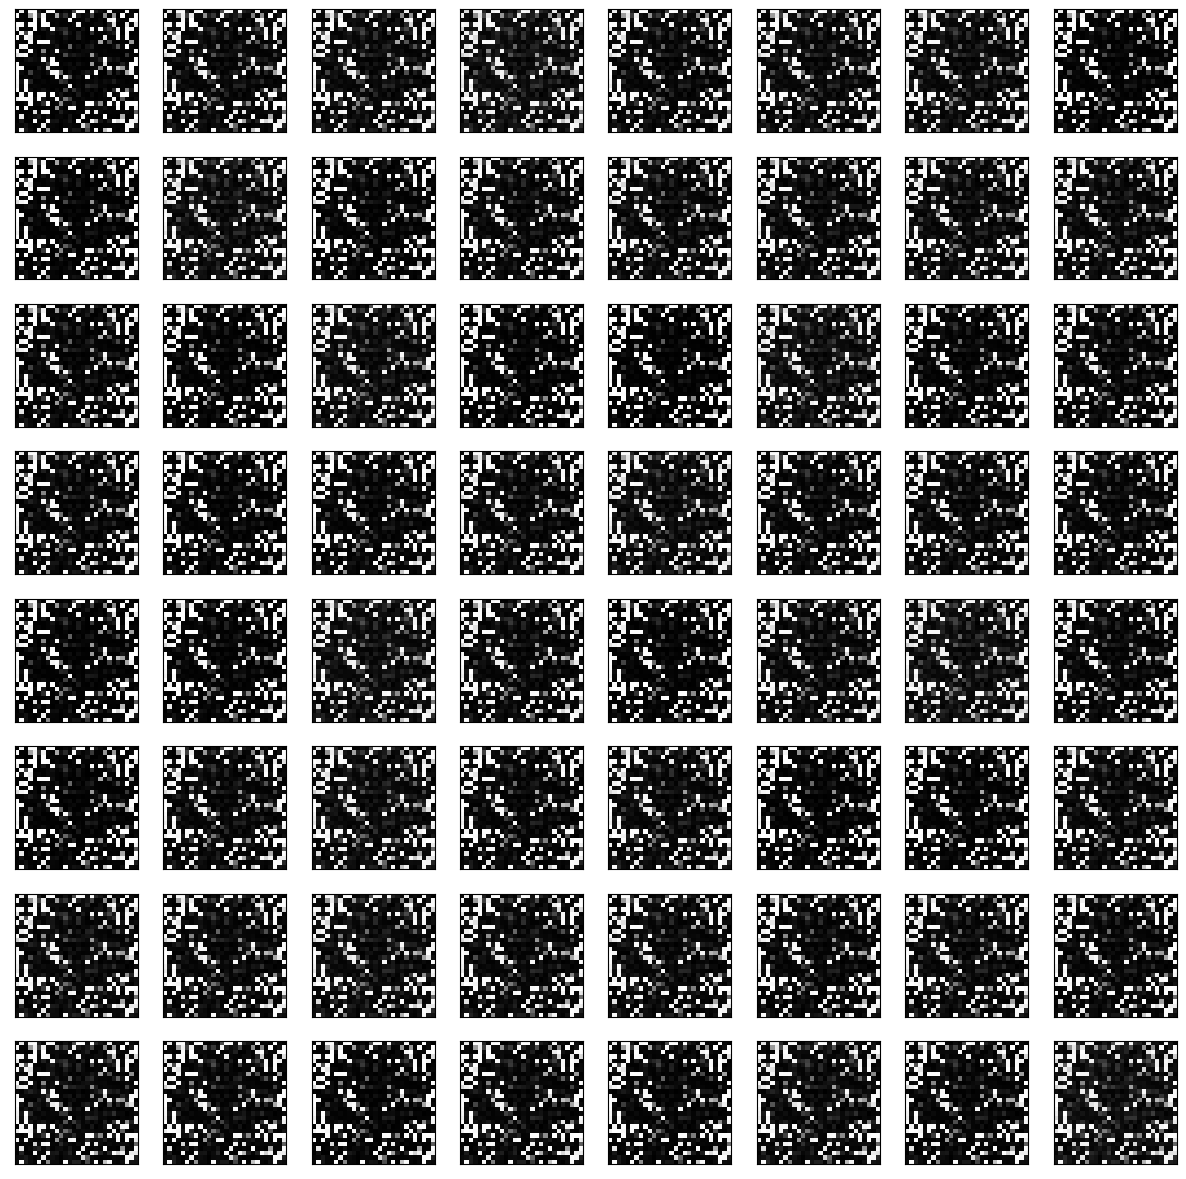

In [7]:
for epoch in range(training_parameters['n_epochs']):
    G_loss = []  # for plotting the losses over time
    D_loss = []
    for batch, (imgs, labels) in enumerate(train_loader):
        batch_size = labels.shape[0]  # if the batch size doesn't evenly divide the dataset length, this may change on the last epoch.
        lossG = train_generator(batch_size)
        G_loss.append(lossG)
        lossD = train_discriminator(batch_size, imgs, labels)
        D_loss.append(lossD)

        if ((batch + 1) % 500 == 0 and (epoch + 1) % 1 == 0):
            # Display a batch of generated images and print the loss
            print("Training Steps Completed: ", batch)
            with torch.no_grad():  # disables gradient computation to speed things up
                noise = torch.randn(batch_size, 100).to(device)
                fake_labels = torch.randint(0, 10, (batch_size,)).to(device)
                generated_data = generator(noise, fake_labels).cpu().view(batch_size, 28, 28)

                # display generated images
                batch_sqrt = int(training_parameters['batch_size'] ** 0.5)
                fig, ax = plt.subplots(batch_sqrt, batch_sqrt, figsize=(15, 15))
                for i, x in enumerate(generated_data):
                    #ax[math.floor(i / batch_sqrt)][i % batch_sqrt].set_title(
                    #    label_descriptions[int(fake_labels[i].item())]) # TODO: In 5.4 you can uncomment this line to add labels to images.
                    ax[math.floor(i / batch_sqrt)][i % batch_sqrt].imshow(x.detach().numpy(), interpolation='nearest', cmap='gray')
                    ax[math.floor(i / batch_sqrt)][i % batch_sqrt].get_xaxis().set_visible(False)
                    ax[math.floor(i / batch_sqrt)][di % batch_sqrt].get_yaxis().set_visible(False)
                # plt.show()
                #fig.savefig(f"./results/CGAN_Generations_Epoch_{epoch}")
                fig.savefig(f"pset/pset3/results/CGAN_Generations_Epoch_{epoch}")
                print(
                    f"Epoch {epoch}: loss_d: {torch.mean(torch.FloatTensor(D_loss))}, loss_g: {torch.mean(torch.FloatTensor(G_loss))}")